In [3]:
!pip install -r ../requirements.txt

  Using cached comm-0.1.4-py3-none-any.whl (6.6 kB)
     |████████████████████████████████| 4.9 MB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████| 154 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 806 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 9.7 MB/s  eta 0:00:01
  Using cached numpy-1.25.2-cp39-cp39-macosx_10_9_x86_64.whl (20.8 MB)
  Using cached pandas-2.1.0-cp39-cp39-macosx_10_9_x86_64.whl (12.2 MB)
  Using cached Pillow-10.0.0-cp39-cp39-macosx_10_10_x86_64.whl (3.4 MB)
     |████████████████████████████████| 409 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 7.2 MB/s eta 0:00:011
  Using cached pyasn1-0.5.0-py2.py3-none-any.wh

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [42]:
import pandas as pd
df = pd.read_pickle("../merged_data.pkl")
# Unnecessary cols
labels_to_drop = [
    'CompanyNumber',
    'EventDate',
    'EventDate_string',
    'StartDate',
    'gvkey',
    'datadate', 
    'yyyy',  
    'mm', 
]
df = df.drop(labels_to_drop, axis=1)
df = df[df['EventType'] != 2]
df['EventType'] = df['EventType'].apply(lambda x: '1' if x == 1 else '0')
df['EventType'].value_counts()
df['Duration'] = df['Duration'].astype(str)
df['Duration'] = df['Duration'].str.replace(r'\s', '', regex=True)
df['Duration'] = df['Duration'].str.split('days').str[0]
df['Duration'] = df['Duration'].astype('float32')

In [43]:
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
og_cols = df_train.columns.tolist()
cols_standardize = [i for i in og_cols if i not in ['Duration', 'EventType']]
cols_leave =[]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [41]:
df.dtypes

DTDmedianFin                float64
DTDmedianNonFin             float64
dummy297fin                 float64
Duration                    float64
EventType                    object
sic                          object
atq                         float64
ltq                         float64
dlcq                        float64
txditcq                     float64
cheq                        float64
lctq                        float64
actq                        float64
invtq                       float64
intanq                      float64
oibdpq                      float64
txpq                        float64
piq                         float64
niq                         float64
revtq                       float64
cogsq                       float64
oancfy                      float64
ivncfy                      float64
fincfy                      float64
dltisy                      float64
dltry                       float64
ceqq                        float64
dpq                         

In [70]:
num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['Duration'].values, df['EventType'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
y_test = labtrans.transform(*get_target(df_test))
val = tt.tuplefy(x_val, y_val)
durations_test, events_test = get_target(df_test)

/Users/thomastan/opt/anaconda3/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:219: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [45]:
y_train

(array([3, 3, 3, ..., 8, 9, 8]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 array([0.472458  , 0.56735075, 0.63755596, ..., 0.84971476, 0.36661017,
        0.21401048], dtype=float32))

In [46]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [47]:
from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

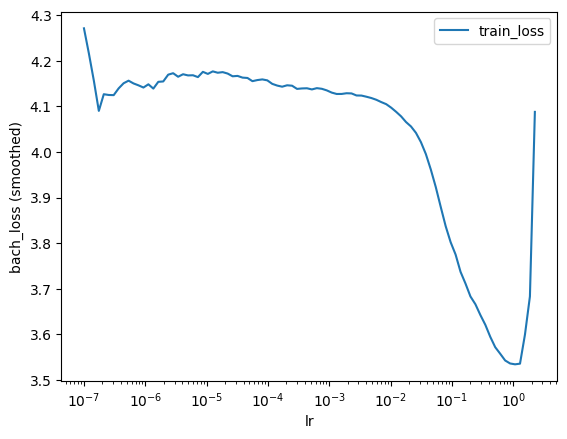

In [48]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [49]:
lr_finder.get_best_lr()

0.10722672220103299

In [50]:
model.optimizer.set_lr(0.01)

In [51]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[4s / 4s],		train_loss: 2.0345,	val_loss: 1.9712
1:	[4s / 9s],		train_loss: 1.9746,	val_loss: 1.9585
2:	[5s / 15s],		train_loss: 1.9606,	val_loss: 1.9514
3:	[5s / 20s],		train_loss: 1.9505,	val_loss: 1.9366
4:	[4s / 25s],		train_loss: 1.9485,	val_loss: 1.9372
5:	[4s / 30s],		train_loss: 1.9423,	val_loss: 1.9273
6:	[5s / 36s],		train_loss: 1.9375,	val_loss: 1.9293
7:	[5s / 41s],		train_loss: 1.9360,	val_loss: 1.9294
8:	[5s / 46s],		train_loss: 1.9326,	val_loss: 1.9211
9:	[5s / 52s],		train_loss: 1.9343,	val_loss: 1.9320
10:	[4s / 56s],		train_loss: 1.9303,	val_loss: 1.9211
11:	[5s / 1m:2s],		train_loss: 1.9280,	val_loss: 1.9141
12:	[5s / 1m:7s],		train_loss: 1.9276,	val_loss: 1.9094
13:	[5s / 1m:12s],		train_loss: 1.9260,	val_loss: 1.9183
14:	[4s / 1m:17s],		train_loss: 1.9241,	val_loss: 1.9093
15:	[4s / 1m:21s],		train_loss: 1.9233,	val_loss: 1.9067
16:	[4s / 1m:25s],		train_loss: 1.9225,	val_loss: 1.9159
17:	[4s / 1m:30s],		train_loss: 1.9253,	val_loss: 1.9235
18:	[4s / 1m:34s],		t

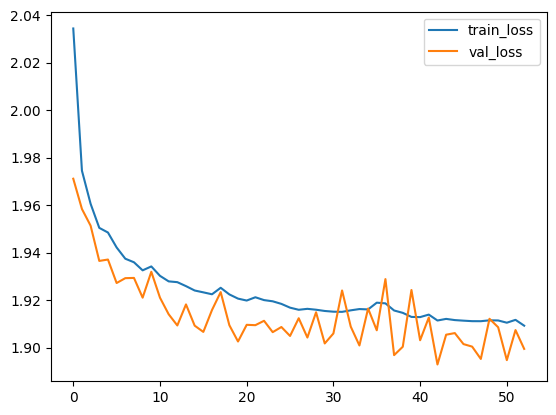

In [52]:
_ = log.plot()

In [53]:
surv = model.predict_surv_df(x_test)

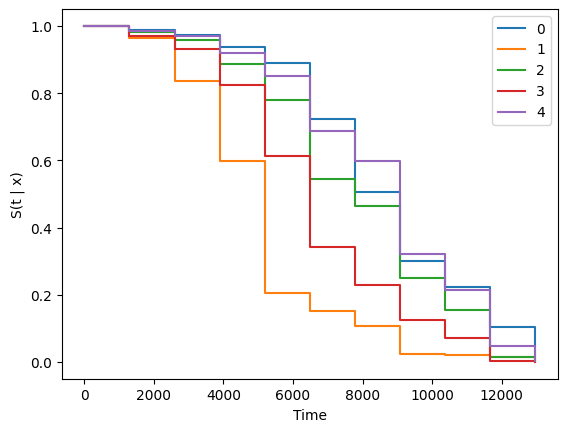

In [54]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [55]:
model.sub = 10

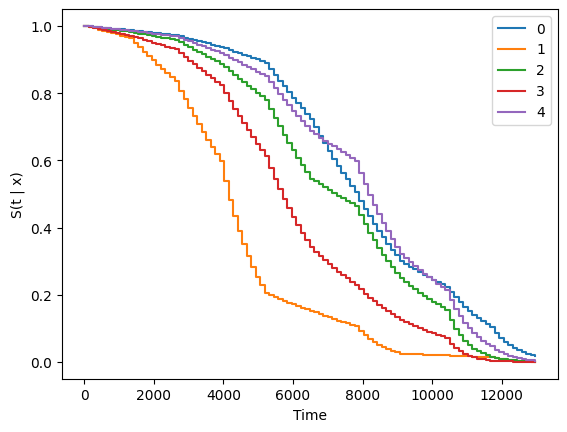

In [65]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

(array([5, 3, 4, ..., 6, 6, 4]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 array([0.45903403, 0.49637407, 0.6705756 , ..., 0.72118473, 0.2667796 ,
        0.03641427], dtype=float32))

In [66]:
ev = EvalSurv(surv, durations_test, events_test.astype(int), censor_surv='km')

/Users/thomastan/opt/anaconda3/lib/python3.9/site-packages/pycox/utils.py:57: UserWarning: start_duration 0 is larger than minimum duration -30.0. If intentional, consider changing start_duration when calling kaplan_meier.
  warnings.warn(f"start_duration {start_duration} is larger than minimum duration {durations.min()}. "


AttributeError: 'Series' object has no attribute 'is_monotonic'

/Users/thomastan/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


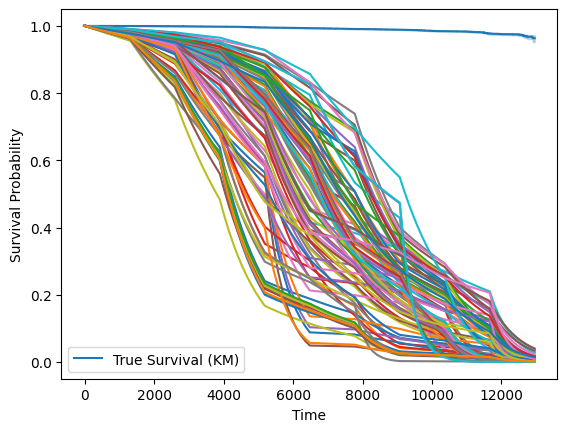

In [74]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Prepare Kaplan-Meier survival curves
kmf = KaplanMeierFitter()
kmf.fit(df_test['Duration'], event_observed=df_test['EventType'])
kmf.plot(label='True Survival (KM)')

# Plot predicted survival curves
for i in range(len(surv)):
    plt.plot(surv.index, surv.iloc[:, i], label=f'Predicted Curve {i+1}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()


In [75]:
from lifelines.utils import concordance_index

# Calculate C-Index
c_index = concordance_index(df_test['Duration'], -surv.values, df_test['EventType'])
print("Concordance Index (C-Index):", c_index)


ValueError: Event times and predictions must have the same shape